# Clustering Customers
In this notebook, I will be performing clustering on a dataset of customers on some shopping mall in hope of identifying all the different types of customers and understand more about them, while also identifying which group of people is the most valuable so that we can ensure they can retain more to spend more.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import shapiro
from sklearn.preprocessing import MinMaxScaler

Import the data and check the sample data by viewing the top 5.

In [2]:
# importing the data
customer_df = pd.read_csv('Customer_Dataset.csv')
customer_df.head()

,CustomerID,Gender,Age,Income (k$),How Much They Spend
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
# check the number of rows there are
customer_df.shape

(200, 5)

Drop the customerId column as they do not contribute to anything meaningful.

In [4]:
# dropping CustomerID and print the first 5 data again
customer_df.drop(columns=['CustomerID'], inplace=True)
customer_df.head()

,Gender,Age,Income (k$),How Much They Spend
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


Renaming the column names so that I don't have to keep typing long column names again.

In [5]:
customer_df.rename(columns={'Income (k$)' : 'Income', 'How Much They Spend' : 'Spending'}, inplace=True)
customer_df.head()

,Gender,Age,Income,Spending
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


Check for any missing values and what unique values are there in the gender column.

In [6]:
# prints for number of null values
print(customer_df.isnull().sum(), end='\n\n')

# check for the unique values in the gender column
print(customer_df['Gender'].unique())

Gender      0
Age         0
Income      0
Spending    0
dtype: int64

['Male' 'Female']


Check the number of males and females and determine whether any gender take up a huge proportion of the data

In [7]:
# check the number of males and females
print(f'Number of males: {np.sum(customer_df["Gender"] == "Male")}')
print(f'Number of females: {np.sum(customer_df["Gender"] == "Female")}')

Number of males: 88
Number of females: 112


No null values, and there are two unique values for gender shown. Now we shall plot the boxenplot for the age, income, and how much they spend column to not only look for outliers, but also the distribution for those columns.

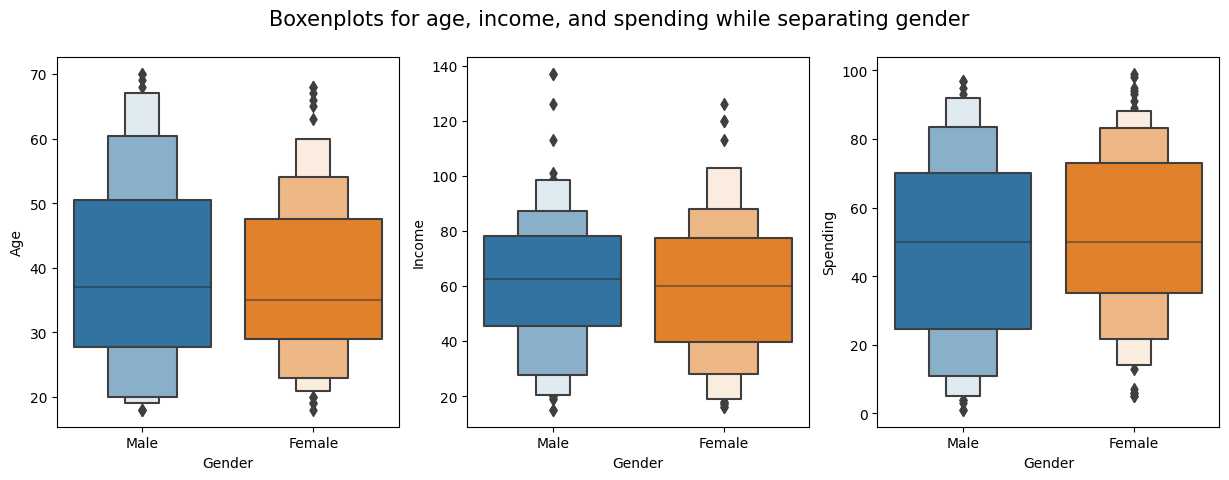

<Figure size 640x480 with 0 Axes>

In [8]:
# 3 subplots lay horizontally
fig, axes = plt.subplots(1, 3)

# manually set the width of the figures longer
fig.set_figwidth(15)
fig.suptitle('Boxenplots for age, income, and spending while separating gender', fontsize=15)

# iterate over the list of axes and plot a boxenplot for each axes
for i, ax in enumerate(axes):
    sns.boxenplot(data=customer_df, x='Gender', y=customer_df.columns[i + 1], ax=ax)

plt.show()
plt.clf()

Based on the above boxenplots, we can see that on the age side, both male and female are skewed to the right, so there are more younger people. Outliers are not too far of from the upper/lower bounds. 

On the income side, both gender seems to be somewhat symmetrical in their distribution. The outliers at the bottom are very close to the lower bound, but the ones above the upper bound can be way above 100k. In the real world, people can have huge salary, but finding them in the public can be rare since only a tiny proportion of people have huge salary (Kochhar, R. (2021)). Thus, although the outliers are way above the upper bound, they are not necessary errors, but potentially a genuine high income earner. I will have to take that into account when training algorithms that are susceptible to big outliers. 

On the spending side, both gender seems to show slight symmetrical distribution, with outliers not too far off from the lower/upper bound.

Next, I am going to try do the same but unifying the genders to show how the data distributes overall.

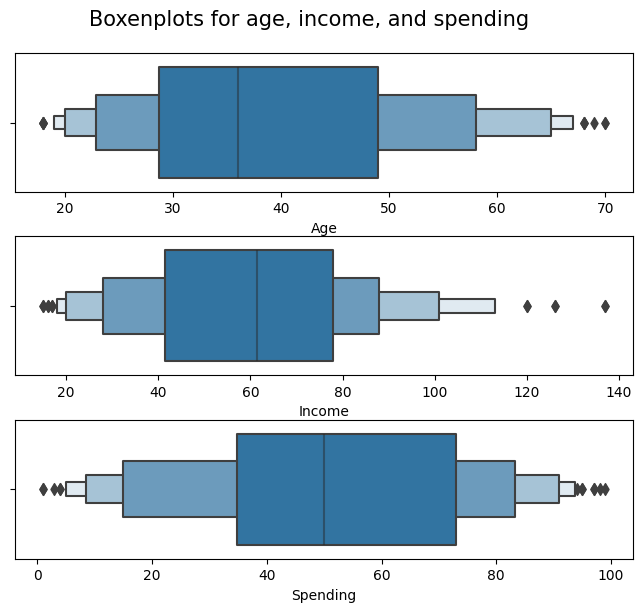

<Figure size 640x480 with 0 Axes>

In [9]:
# 3 subplots lay vertically
fig, axes = plt.subplots(3, 1)

# manually adjust the figure size so that the bars can be seen easily and properly
fig.set_figwidth(7)
fig.set_figheight(6)
fig.suptitle('Boxenplots for age, income, and spending', fontsize=15)
fig.tight_layout()

# iterate over the list of axes and plot the boxenplot for each axes
for i, ax in enumerate(axes):
    sns.boxenplot(data=customer_df, x=customer_df.columns[i + 1], ax=ax)

plt.show()
plt.clf()

Based on the above boxenplot, we can see that for age, it is also positively-skewed, meaning more overall younger shoppers, with outliers not too far from the lower/upper bound. For the income, it may seem like positively-skewed because the smaller boxes near the upper bound are more elongated. In the real world, income is usually positively-skewed, so maybe due to this dataset having only 200 data, it does not represent the positively-skew well enough. The outliers are essentially similar to the previous boxenplot. For the spending, it seems to be slightly symmetrical or negatively-skewed. For better visualisation, I will also try to plot a histogram with KDE as well.

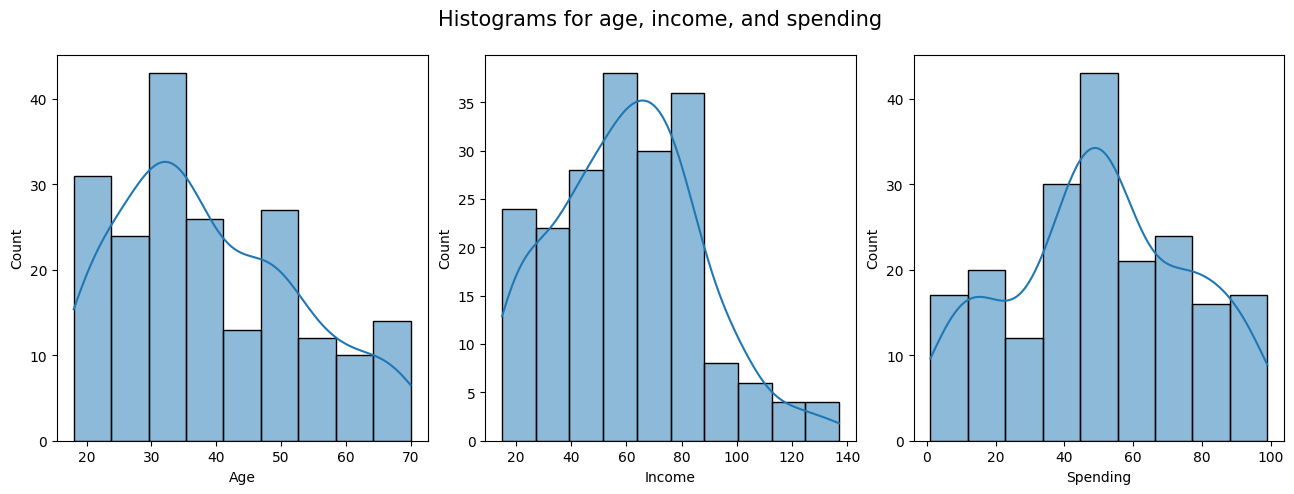

<Figure size 640x480 with 0 Axes>

In [10]:
# 3 subplots lay horizontally
fig, axes = plt.subplots(1, 3)

# manually set the width of the figure longer
fig.set_figwidth(13)
fig.suptitle('Histograms for age, income, and spending', fontsize=15)
fig.tight_layout()

# iterate over the list of axes and plot a histogram for each axes
for i, ax in enumerate(axes):
    sns.histplot(data=customer_df, x=customer_df.columns[i + 1], ax=ax, kde=True)

plt.show()
plt.clf()

We can now clearly see that age and income are actually positively skewed, while spending seems to be symmetrical. With more data, we could probably see the positively-skewed graphs for age and income, while showing a more normal curve for the spending column. Now we shall do some hypothesis testing to confirm if all the qualitative columns follow the Gaussian distribution. This can determine whether we can do certain things, such as whether we can use the Gaussian Mixture Model for clustering.

To do the hypothesis testing, I will use the Shapiro-Wilk test which tests whether a sample of data came from a normal distribution. (Malato, G. (2023))

Let H0 be the column of data generated from a normal distribution.
And let H1 be the column of data that did not generate from a normal distribution.

In [11]:
columns = customer_df.columns[1:]

for col in columns:
    print(f'Hypothesis test for {col}: {shapiro(customer_df[col])}')

Hypothesis test for Age: ShapiroResult(statistic=0.9516184329986572, pvalue=2.7109526854474097e-06)
Hypothesis test for Income: ShapiroResult(statistic=0.9783905148506165, pvalue=0.003537340322509408)
Hypothesis test for Spending: ShapiroResult(statistic=0.9694603085517883, pvalue=0.00024227304675150663)


Based on the results, the p-value for all the columns are below 0.05, hence rejecting the H0 on all columns. We can confirm that our dataset do not follow the Gaussian distribution.

Now we shall see how these features correlate one another.

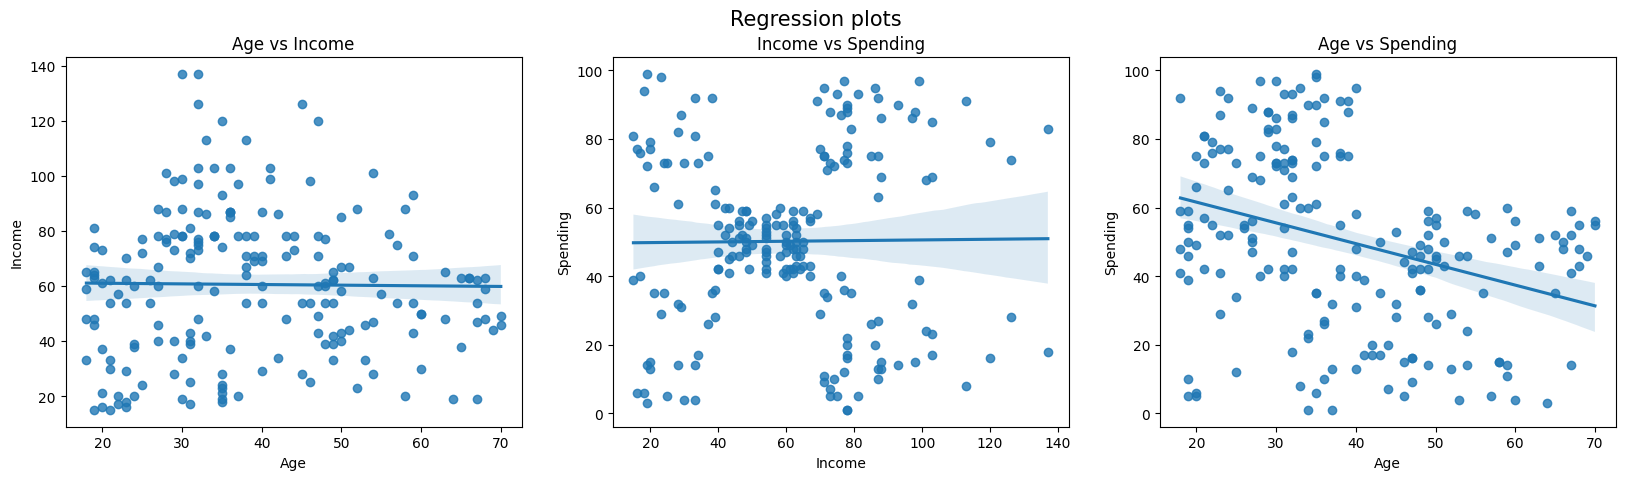

<Figure size 640x480 with 0 Axes>

In [12]:
# 3 subplots lay horizontally
fig, axes = plt.subplots(1, 3)

# manually set the width of the figure longer
fig.set_figwidth(20)
fig.suptitle('Regression plots', fontsize=15)

# plot 3 regression plots
sns.regplot(data=customer_df, x='Age', y='Income', ax=axes[0])
sns.regplot(data=customer_df, x='Income', y='Spending', ax=axes[1])
sns.regplot(data=customer_df, x='Age', y='Spending', ax=axes[2])

# set each subplots their title name
axes[0].set_title('Age vs Income')
axes[1].set_title('Income vs Spending')
axes[2].set_title('Age vs Spending')

plt.show()
plt.clf()

Based on the above regplots, it seems like Age vs Income and Income vs Spending have no correlation, while Spending vs Age has a slight negative correlation. For Age vs Income, the income seems to be relatively stable regardless of age. For Income vs Spending, it seems to be pretty unique in that instead of having blobs of data altogether like in Age vs Income, it forms a few somewhat obvious clusters while showing no correlation and having big uncertainty for the regression line. And for the Age vs Spending, it seems like there is a weak correlation between Age and Spending, which may imply that younger people spend more than older people.

Besides correlation, there are some interesting observations with regards to the clusters formed in the regplots. For Income vs Spending, we can easily see 5 clusters in the regplot. The first cluster with low income but high spending may be youths who tend to do shopping spree on material goods they want (if stereotype, they are females in their youth). The second cluster with high income and high spending may be wealthy people, probably middle-age people who are wanting to get luxury material goods. The third cluster with medium income and medium spending in the center is probably a group of average people buying goods in moderate amount and in average quality. The fourth cluster with low income and low spending may simply be low income people who are aware of their incomes, thus spending less on goods. The last cluster with high income but low spending may be wealthy people with a strong mindset on how they spend, thus these people may be wise on what they spend even with their high incomes.

When we look into Age vs Spending, we may observe two huge clusters. The cluster with low age but high spending may be youths who are onto buying material goods and getting the luxury goods they want, while the second cluster with higher age but low spending may be people getting wiser about their spending thus they spend less.

Unfortunately for Age vs Income, there is no visible clusters, thus no further comments can be made by this regplot.

Since we only have 3 continuous features, we can simply plot a 3D graph to visualise how the clusters would form, first without gender, or we can use the Income vs Spending regplot but the colour of the data represent the age.

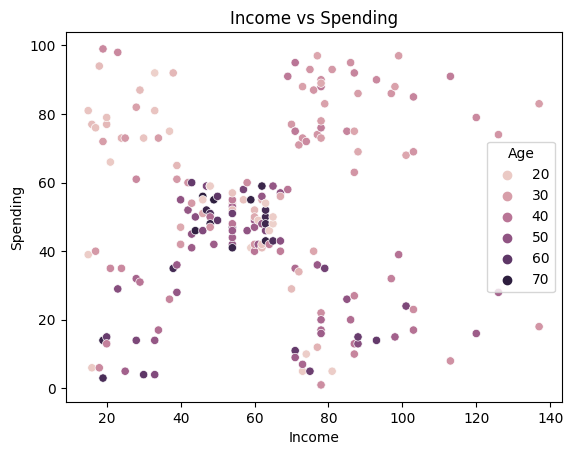

<Figure size 640x480 with 0 Axes>

In [13]:
# Firstly, based on our Income vs Spending regplot, I will plot it again with scatterplot but now the colour represents the age
sns.scatterplot(data=customer_df, x='Income', y='Spending', hue='Age')
plt.title('Income vs Spending')
plt.show()
plt.clf()

Based on the scatterplot above, we can confirm that on the first cluster with low income but high spending, they are youths as the overall data there are the brightest. The second cluster with high income and high spending show slightly overall darker colour than the first cluster, indicating young-to-middle-age people who are earning their highest who are also willing to spend a lot of money on material goods. The third cluster shows a wide variety of colour, showing no visible patterns. The fourth and fifth clusters have a slightly overall darker data points than the second cluster, indicating older people may be more wiser on their spendings.

Now I will try plotting a 3D graph to illustrate how all this will look like. I will also add the gender feature to see if it can create new clusters.

In [14]:
# Plotting a 3D scatterplot with plotly express. If you get an error about nbformat wrong version, do `pip install --upgrade nbformat` and then reload vscode
fig = px.scatter_3d(customer_df, 'Income', 'Spending', 'Age', 'Gender')
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

Without looking at the gender first, we can confirm that the first cluster (low income high spending) has the lowest overall age due to the depth on the age axis, with most people in this cluster in their 20s. The second cluster (high income high spending) has the second lowest overall age, with most being in their 30s. The third cluster encompass the whole age range from around 20 to 70, thus forming a group of average people with average income and spending. The fourth and fifth clusters seem to have mostly people in their 30s, 40s, and 50s where both clusters have low spending but have either low or high income.

But when we factor the gender feature into the equation, what we see is a mix of gender all over the scatterplot. For every clusters, the gender mixed well enough that it makes the feature totally irrelevant because it makes no discernible pattern in the scatterplot at all. So when we do clustering, we can simply drop the gender feature.

However, the age feature doesn't seem to create any new visible clusters as well, it only provide some insights only. I may be wrong, so I need to use clustering algorithm to determine the clusters.

Now I want to determine whether I want to drop the Gender variable, so I would want to do PCA to see how the PCA components with the big explained variance has to say about the Gender variable. But the problem is our data is not normal, which can make PCA producing degraded results. Also, we have a binary categorical value which is nominal, which should not work well with PCA. T-SNE on the other hand, can't be easily used to do feature selection. Luckily in my case, I can just visualise the data manually and use my own judgement to determine whether I should drop them. In future scenarios with more complex dataset, I will need to find more proper ways of doing feature selection.

In [15]:
# drop the gender feature and show a sample top 5 output
customer_df2 = customer_df.drop(columns=['Gender'])
customer_df2.head()

,Age,Income,Spending
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40


## Model training and selection
Now is time to create some clustering algorithm to create the cluster.

In [16]:
# import all the necessary libraries
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, silhouette_samples
import matplotlib.cm as cm

I would like to scale our data because all the features do not have the same units and scale even though their scaling are almost similar. I cannot use StandardScalar as it assumes normality which is not the case for our dataset. It's even stated on the scikit-learn website "they might behave badly if the individual features do not more or less look like standard normally distributed data". So instead I use the MinMaxScaler to scale our data. 

In [17]:
# normalise the data first as the features are not on the same units/scale.
# duplicate the dataframe
normal_df = customer_df2.copy()

mms = MinMaxScaler()

# iterate over the columns and normalise each column
for col in normal_df.columns:
    normal_df[col] = mms.fit_transform(normal_df[[col]])

normal_df.head()

,Age,Income,Spending
0,0.019231,0.000000,0.387755
1,0.057692,0.000000,0.816327
2,0.038462,0.008197,0.051020
3,0.096154,0.008197,0.775510
4,0.250000,0.016393,0.397959


The first algorithm I will be using is K-Means, a simple and efficient way to cluster the data. I will be iterating over a range of k values where k is the number of cluster. For each value of k, run the model with the specified k, and store the value of the SSE (sum squared of error),the silhouette score, and the Calinski-Harabasz Index into their respective lists and the graphs to visualise how their scores vary with k values. 

SSE finds the error between each point and the center of their own cluster, squaring them individually and sum them up together. I can then plot the graph between the number of k and the SSE so I can use the "elbow method" to find the optimal k value. Silhouette score allows me to see for any cluster overlapping and generally how spread the data are to their neighbouring cluster. I would have to look for the highest average score which would be the data points being close to their actual cluster. Calinski-Harabasz Index finds the ratio between how spread out are the cluster centroids from one another to how spread out are the data points to their own cluster centroid. I need to find the highest Calinski-Harabasz value which would be mean more spread out clusters and more tightly packed clusters.

When doing K-Means, I will use the k-means++ initialisation as it finds new clusters based on a probability distribution where the further the points from the current centroid, the higher the probability of initialising the next centroid at the said point. This makes initialisation much quicker and potentially accurate as it relies on place the next centroid near the "other end" of the data points. Even with k-means++, I can't guarantee that I can get the best cluster, so I would set n_init to 20 instead of auto. 

In [18]:
# list of k values and scores
k_list = range(2, 11)
sse = []
silhouette_avgs = []
silhouette_values = []
labels = []
ch_index = []

# iterate over the list of k, create the model and then append the results
for k in k_list:

    # create the model and then fit the data
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=20).fit(normal_df)

    # append the scores
    sse.append(kmeans.inertia_)     # the SSE, which is the inertia
    silhouette_avgs.append(silhouette_score(normal_df, kmeans.labels_))  # the silhouette score, taking in the dataset and the corresponding clustering
    silhouette_values.append(silhouette_samples(normal_df, kmeans.labels_))     # the silhouette values, to be plotted on the silhouette plot
    labels.append(kmeans.labels_)   # appending the labels 
    ch_index.append(calinski_harabasz_score(normal_df, kmeans.labels_))     # the calinski_harabasz index, similar to silhouette

# create a dataframe to store all the results
scores = pd.DataFrame({
    'k_value' : list(k_list),
    'SSE' : sse,
    'silhouette_average' : silhouette_avgs,
    'silhouette_values' : silhouette_values,
    'labels' : labels,
    'calinski_harabasz' : ch_index
})

scores.head()

,k_value,SSE,silhouette_average,silhouette_values,labels,calinski_harabasz
0,2,22.560775,0.365250,"[0.2423459398098435, 0.4500519376664523, 0.015...","[0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, ...",130.246415
1,3,17.370109,0.365043,"[0.22727240139920724, 0.42444635697081323, 0.0...","[1, 1, 0, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, ...",113.591121
2,4,12.650288,0.392319,"[0.4606921871556925, 0.425818606713471, 0.1275...","[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, ...",127.829349
3,5,10.303965,0.406117,"[0.06670610184350084, 0.6601621638232382, 0.28...","[1, 4, 1, 4, 1, 4, 1, 4, 3, 4, 3, 4, 3, 4, 1, ...",128.203462
4,6,8.385099,0.423486,"[0.057691405582150766, 0.6516617727180166, 0.0...","[4, 5, 4, 5, 4, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, ...",134.266234


Now is time to visualise the scores. I will plot the graph of the SSE over k_value to see how SSE drops over k_value, the silhouette average value over k_value as well, and the calinski_harabasz score over k_value.

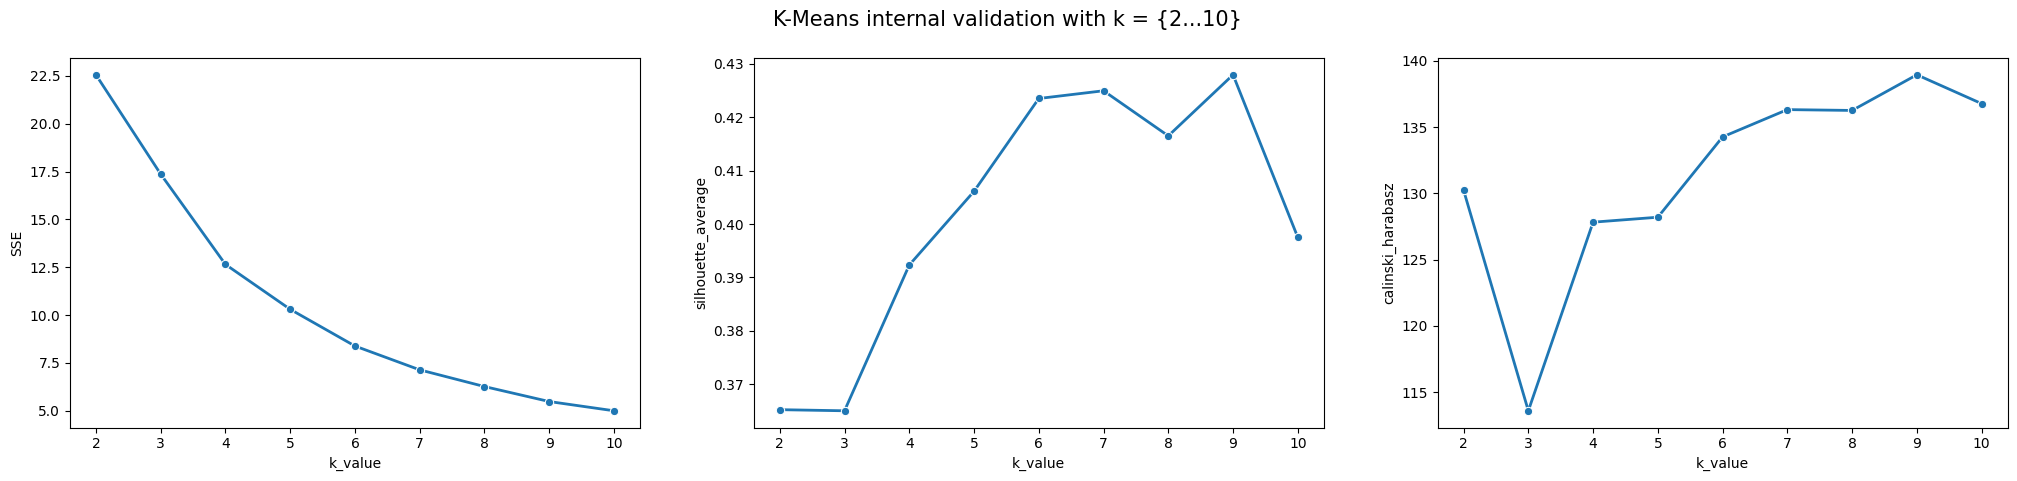

<Figure size 640x480 with 0 Axes>

In [19]:
# 3 subplots lay horizontally, with each graph showing the score
fig, axes = plt.subplots(1, 3)
plt.style.use('Solarize_Light2')

# manually set the width of the figures longer
fig.set_figwidth(25)
fig.suptitle('K-Means internal validation with k = {2...10}', fontsize=15)

col_list = ['SSE', 'silhouette_average', 'calinski_harabasz']

# iterate over the list of axes and plot a lineplot for each axes
for i, ax in enumerate(axes):
    sns.lineplot(data=scores, x='k_value', y=col_list[i], ax=ax, marker='o')

plt.show()
plt.clf()

Based on the results above, it seems as though a k value of 4, 6, 7, or 9 sounds appealing. For the SSE, the elbow is the most visible at k=4, and slightly visible on k=6. For the silhoutte, k=6 score seems to be way higher than k=4 and is almost as high as k=7 which is also almost as high as k=9. And for calinski harabasz, k=6 is not as high as the higher value of k, but k=4 is way below. With k=6, the silhouette and the calinski harabasz is not too far of from the highest scores which is at k=9, and is almost tie with k=7. Thus, I think k=6 might be the most optimal number of clusters. k=9 might be a bit too many clusters.

Now I will plot the silhouette plots for all the values of k.

In [20]:
def plot_silhouette(ax, k, sample_silhouette_values, labels, silhouette_avg, title):
    # code for the silhouette plot is taken from the sklearn website and modified to my needs
    # link: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
    y_lower = 10
    for i in range(np.min(labels), k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / len(np.unique(labels)))
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title(title)
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


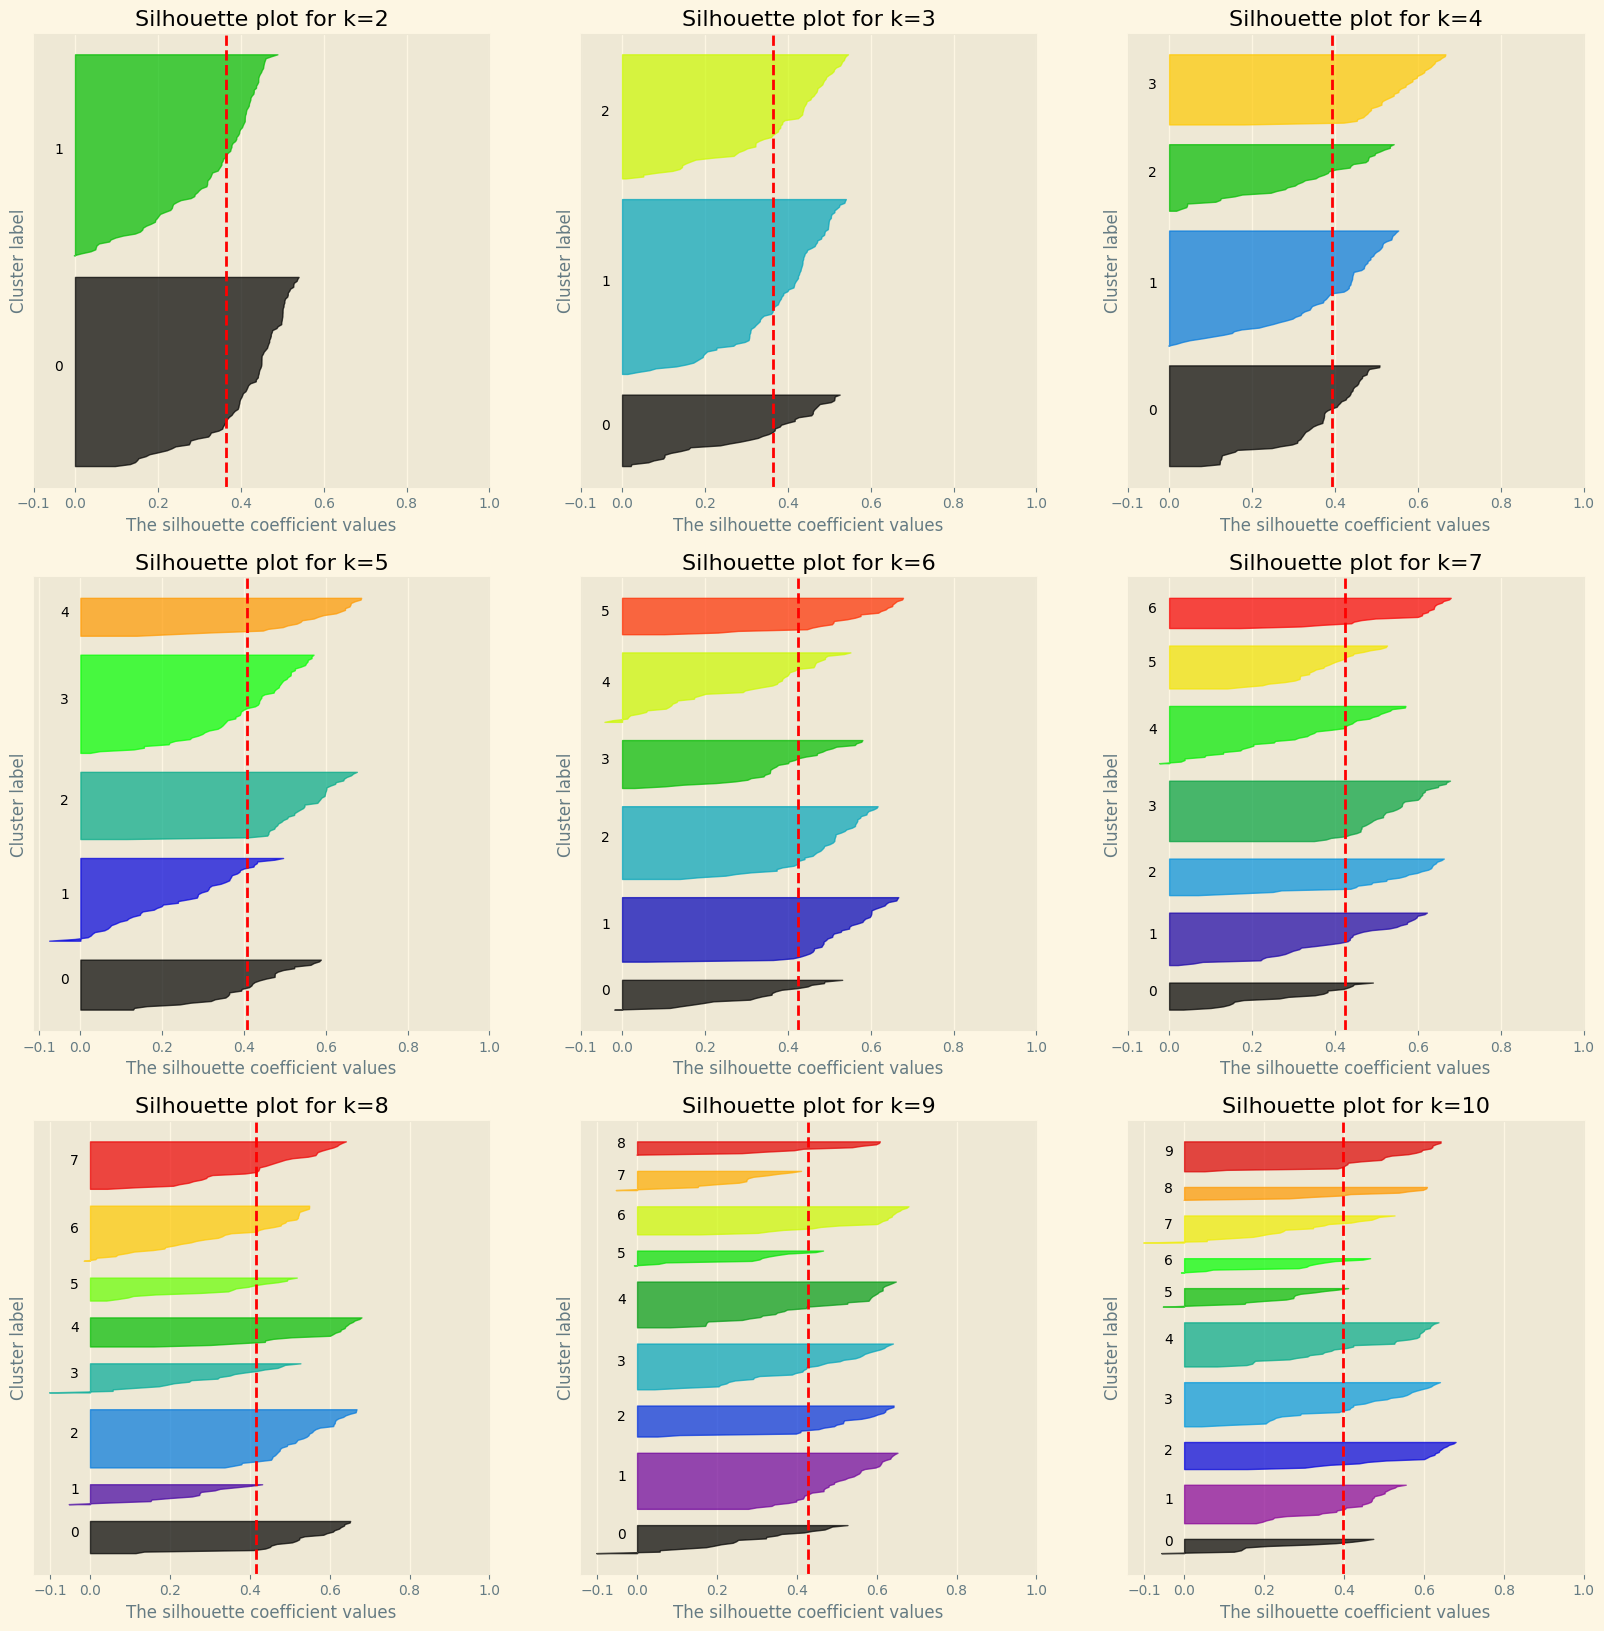

<Figure size 640x480 with 0 Axes>

In [21]:
# plot the subplots
fig, axes = plt.subplots(3, 3)
fig.set_figwidth(20)
fig.set_figheight(20)

# iterate over the rows and columns of the subplots
for row in range(3):
    for col in range(3):
        # get the index for each subplot and then call the function to plot the silhouette graph
        idx = (3 * row) + col

        # the function to draw the graph will take in the plot ax, the k value, silhouette values, the predicted labels, and the silhouette average score
        plot_silhouette(axes[row][col], scores['k_value'][idx], scores['silhouette_values'][idx], scores['labels'][idx], scores['silhouette_average'][idx], f"Silhouette plot for k={scores['k_value'][idx]}")

plt.show()
plt.clf()


In the silhouette plots, we can see that:
1. When k <= 4, there are no silhouette values that are below 0, while the rest has at least one cluster where the lowest value dip below 0. However, all k <= 4 has an average silhouette value less than 0.4, which is below than any other average silhouette score for k > 4.
2. When k >= 8, the difference between the silhouette coefficient values for the highest and the lowest peak value for each cluster can start to get massive, potentially more than 0.2 difference. Whereas in k = 2 and k = 3, there is little to no fluctation.

In conclusion, this goes to show that there is no perfect k value for this clustering method. The best thus far would be k = 6 since it has a relatively high average silhouette score.

Now I am going to show the 3D graph again to see how the clustering with k=6 would look like.

In [22]:
# create the model again with k=6, fit the data and get the predicted labels
labels = KMeans(n_clusters=6, init='k-means++', n_init=20).fit(normal_df).labels_

# get the silhouette values and the average score to plot the silhouette plot
sample_silhouette_values = silhouette_samples(normal_df, labels)
silhouette_avg = silhouette_score(normal_df, labels)

In [23]:
# copy the dataframe so that if I want to rerun the code above, the original dataframe won't have the label column
final_df = customer_df2.copy()

final_df['label'] = labels

# plot the 3D scatterplot
fig = px.scatter_3d(final_df, 'Income', 'Spending', 'Age', 'label')
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

Based on the final clustering done from K-Means and visualised, we can see 4 of the clusters on each corner of the 3D scatterplot being clearly shown, as I have described them earlier (low income high spending in their 20s, high income high spending in their 30s, low income low spending in their 30s/40s/50s, and high income low spending in their 30s/40s/50s). In the middle (medium income medium spending) seems to split into two clusters, where the bottom cluster are people in their 30s or younger, while the top cluster are people in their 40s or beyond. There seems to be 2 outliers where two young people has very low or no income with little to average spending, and they seem to be classified under the young people with medium income medium spending.

Unfortunately, K-Means assume the clusters will be spherical, which is not necessary in our case as shown in the clustering above. Besides, K-Means can be quite susceptible to outliers as well, which exists in our dataset. I will be trying out other models and see how it goes.

I want to try out the Gaussian Mixture Model (GMM) next. Despite it being a soft clustering, it is able to form clusters that are not spherical unlike K-Means. But the problem is that our data do not follow the Gaussian distribution, and the model expected the dataset to follow the Gaussian distribution to even group the data into a cluster (Ellis, C. (2022)).

In [24]:
# import necessary libraries
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

Rather than trying out a distance-based model, I will be trying out a density based model, where I will cluster data based on density of the data. This should allow me to cluster data that are not spherical unlike K-means, and can also not group up the outliers and leave them as they are. Thus, I will be trying out DBSCAN next.

When doing DBSCAN, we will have to fiddle around 2 hyperparameters, they will determine whether the points can be turned into a core point, which is defined by: the "size of the area" or the Eps-neighbourhood of the point, and also requiring how many points within the Eps-neighbourhood, or number of MinPts. (Ester, M. et al. (1996))

So the problem now is, how do I select Eps-neighbourhood and MinPts? Unfortunately, there is no objective way to determine. For the MinPts, the rule of thumb is to have twice the dimension of the data, or 6 MinPts in our case, or at the very least, one more than the number of the dimension of the data, which can be 4 MinPts in our case. Our dataset may be pretty small, so I do not need to have large MinPts. For Eps-neighbourhood, I would have to find the distance of all the points to their k-th neighbour where k is the selected MinPts. Then, sort the distances in descending order and use the elbow method to find the Eps-neighbourhood value (Mullin, T. (2020)). Unfortunately, when picking the distances to the neighbours, I couldn't figure out whether to take the nearest distance, the farthest distance, or the average distance since all sources I can find do things differently. Even the source I referenced just now said to use average distance, but the author used the nearest distance on her sample code. So I will have to do some hyperparameter tuning with 3 different Eps-neighbourhood values.

In [86]:
# I use the nearestneighbors class because it provides a way to easily get the distances for each point to their neigbours
# create a nearestneighbours model fitted with our normalised dataset and set n=6 as I would want to have 6 MinPts
neighbours = NearestNeighbors(n_neighbors=6).fit(normal_df)    
distances, _ = neighbours.kneighbors(normal_df)   # get the distance between points

# wrangling the distance object a bit
distances = np.sort(distances, axis=0)  # unfortunately, there is no easy where to sort data by descending, so I have to look at the elbow from the other side

# create a dataframe to store the nearest, average, and highest distances
distances_df = pd.DataFrame({'nearest' : distances[:,1], 'average' : np.mean(distances, axis=1), 'furthest' : distances[:,-1]})
distances_df

,nearest,average,furthest
0,0.019231,0.031803,0.057929
1,0.019231,0.033205,0.059158
2,0.019231,0.034368,0.060838
3,0.019231,0.035514,0.060838
4,0.020408,0.036518,0.061196
...,...,...,...
195,0.155053,0.200076,0.292371
196,0.174689,0.209107,0.302029
197,0.222444,0.231624,0.315523
198,0.231576,0.241899,0.328218


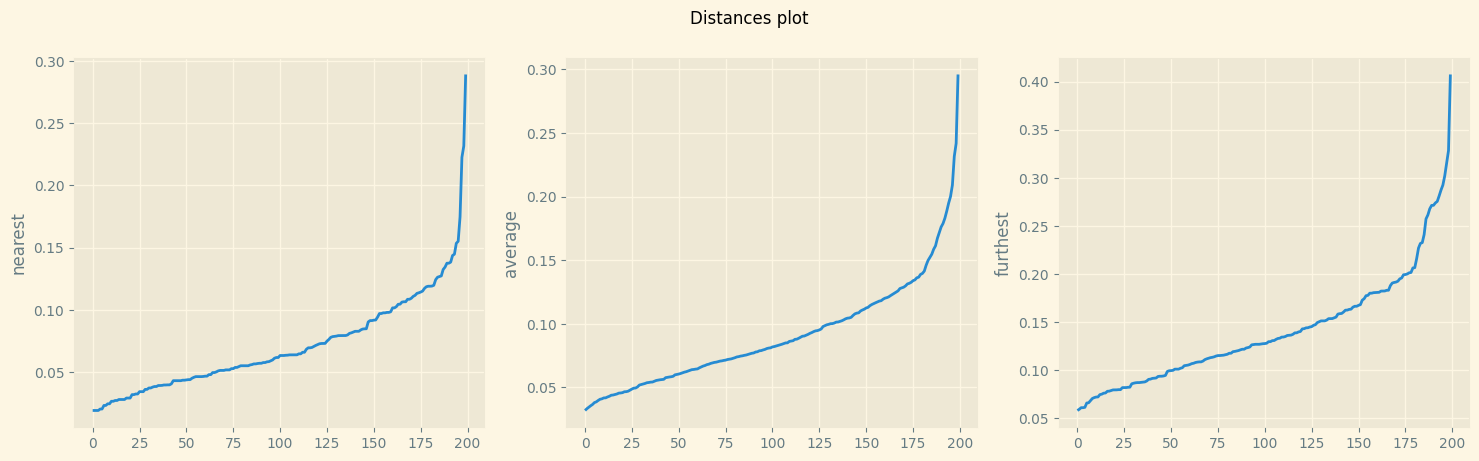

In [87]:
# create subplots
fig, axes = plt.subplots(1, 3)

fig.set_figwidth(18)
fig.suptitle('Distances plot')

# iterate over columns, plot the distance graphs
for i, col in enumerate(distances_df.columns):
    sns.lineplot(data=distances_df, y=col, x=distances_df.index, ax=axes[i])

plt.show()

Based on the distance graph above: 
- For the nearest distance, the elbow lies at around 0.15
- For the average distance, the elbow lies at around 0.14
- For the furthest distance, the elbow lies at 0.2

Next, just like K-Means, I will iterate over a list of hyperparameters and then check the results.

In [88]:
eps_list = [0.15, 0.14, 0.2]

# similar to k-means
acceptable_eps = []
silhouette_avgs = []
silhouette_values = []
labels = []
ch_index = []
# I'll have a dictionary to store the normal_df with different labelling from different hyperparameter
normal_df_list = {}

for eps in eps_list:
    # create the model and then fit the data
    dbscan = DBSCAN(eps=eps, min_samples=6).fit(normal_df)

    # create a temporary copy of the normal_df, merge with the labels, and remove the outliers
    # this is to then store into the normal_df_list
    temp_df = normal_df.copy()
    temp_df['label'] = dbscan.labels_

    # append the dataframe into the dictionary of normal_df
    normal_df_list[f'{eps}'] = temp_df

    # append the scores
    acceptable_eps.append(eps)
    silhouette_avgs.append(silhouette_score(temp_df.drop(columns=['label']), temp_df['label']))  # the silhouette score, taking in the dataset and the corresponding clustering
    silhouette_values.append(silhouette_samples(temp_df.drop(columns=['label']), temp_df['label']))     # the silhouette values, to be plotted on the silhouette plot
    labels.append(temp_df['label'])   # appending the labels 
    ch_index.append(calinski_harabasz_score(temp_df.drop(columns=['label']), temp_df['label']))     # the calinski_harabasz index, similar to silhouette

scores = pd.DataFrame({
    'eps' : acceptable_eps,
    'silhouette_average' : silhouette_avgs,
    'silhouette_values' : silhouette_values,
    'labels' : labels,
    'calinski_harabasz' : ch_index
})

scores.head()

,eps,silhouette_average,silhouette_values,labels,calinski_harabasz
0,0.15,0.131008,"[-0.17846524355971474, 0.04067573933139729, 0....",0 -1 1 0 2 -1 3 0 4 -1 ...,31.078572
1,0.14,0.267194,"[-0.4789271025986413, 0.6504071208170434, -0.2...",0 -1 1 0 2 -1 3 0 4 -1 ...,49.818714
2,0.20,0.217934,"[-0.012640631405362592, 0.11842322855940147, 0...",0 -1 1 0 2 -1 3 0 4 0 ...,4.649295


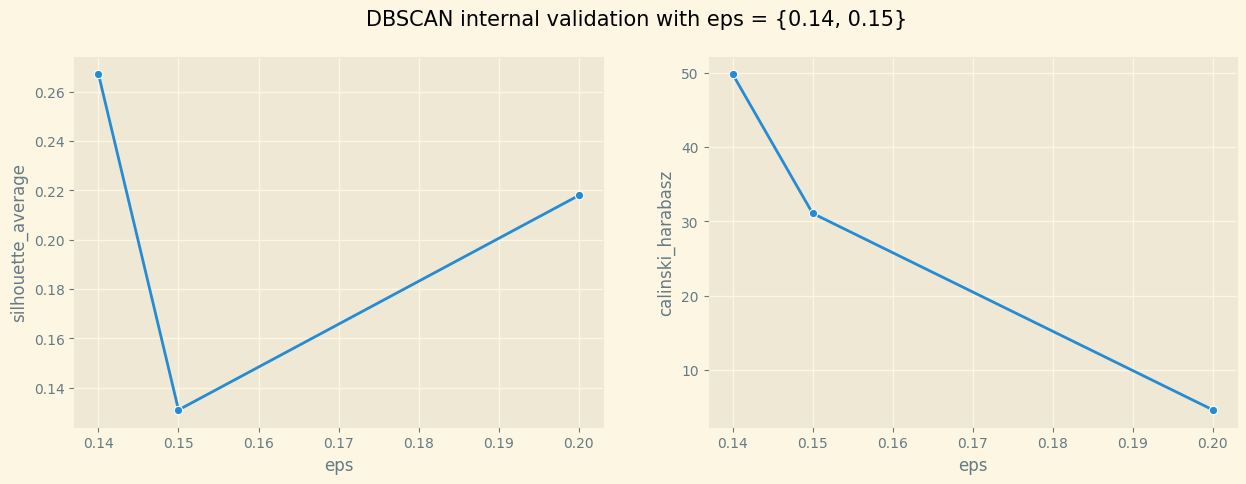

<Figure size 640x480 with 0 Axes>

In [89]:
# 3 subplots lay horizontally, with each graph showing the score
fig, axes = plt.subplots(1, 2)

# manually set the width of the figures longer
fig.set_figwidth(15)
fig.suptitle('DBSCAN internal validation with eps = {0.14, 0.15}', fontsize=15)

col_list = ['silhouette_average', 'calinski_harabasz', 'davies_bouldin']

# iterate over the list of axes and plot a lineplot for each axes
for i, ax in enumerate(axes):
    sns.lineplot(data=scores, x='eps', y=col_list[i], ax=ax, marker='o')

plt.show()
plt.clf()

Immediately, I can already see how DBSCAN is pretty bad compared to the K-Means as the silhouette average and calinski harabasz are lower than some of the k values in K-Means even when eps=0.14. This is because when we calculate the silhouette score, it also take into account the outlier cluster which tends to have pretty bad silhouette values. I will also plot the silhouette graphs to see how the clusters distribute.

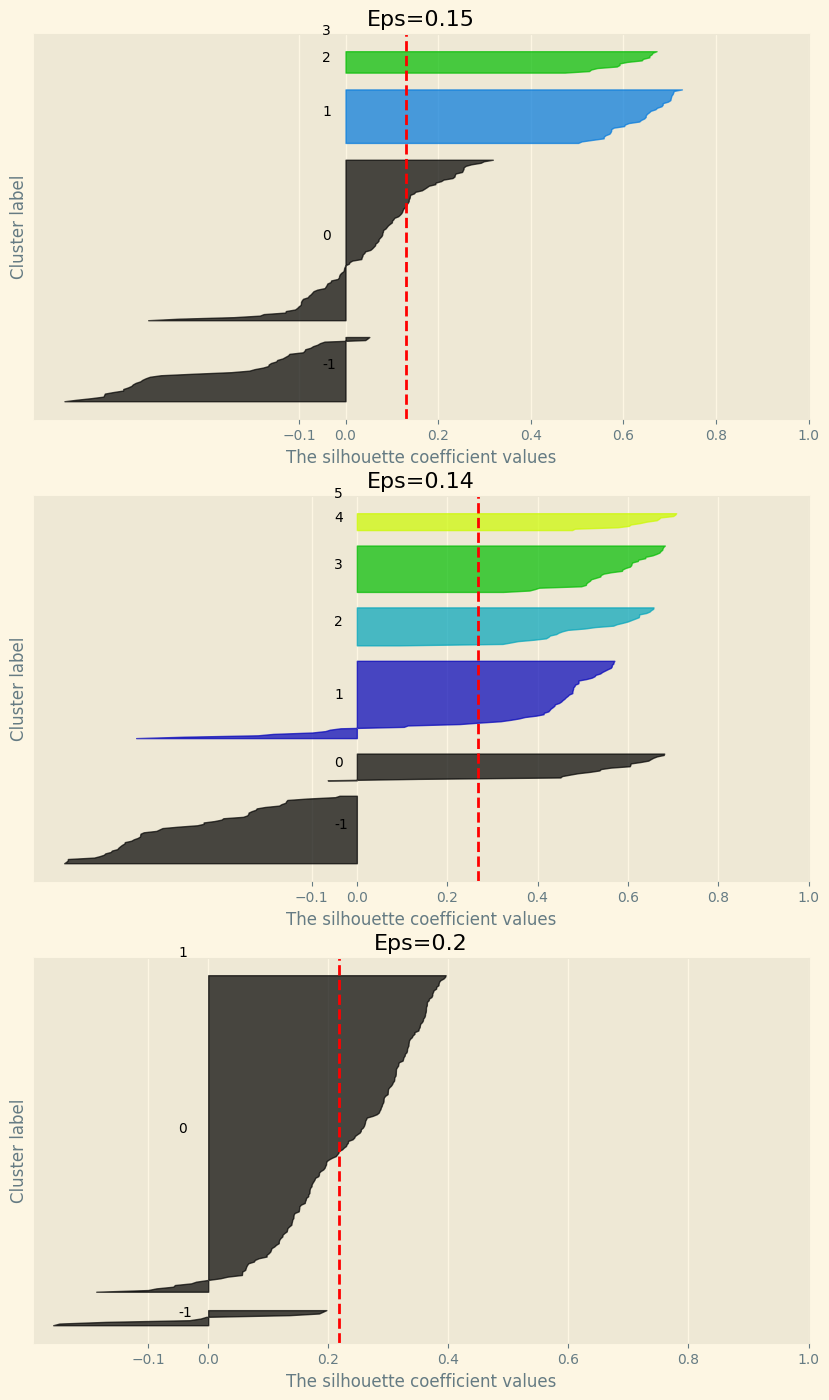

<Figure size 640x480 with 0 Axes>

In [90]:
# plot the subplots
fig, axes = plt.subplots(3, 1)
fig.set_figwidth(10)
fig.set_figheight(17)

# iterate over the rows of the subplots
for i in range(3):
    # the function to draw the graph will take in the plot ax, the k value, silhouette values, the predicted labels, and the silhouette average score
    plot_silhouette(axes[i], len(np.unique(scores['labels'][i])), scores['silhouette_values'][i], scores['labels'][i], scores['silhouette_average'][i], f'Eps={scores["eps"][i]}')

plt.show()
plt.clf()


Apparently, eps=0.14 is somewhat good without the outliers cluster, but because one of the cluster dip way below negative, which means there are data that are literally misclassified, pulling down the average silhouette score. But after all, finding the average distances to find the Eps_neighbourhood can still give the best value.

Before we conclude our hypertuning on DBSCAN, notice that when eps=0.2, it produces one cluster, which is useless. But at eps=0.15, it at least managed to produce a few clusters but with a relatively poor scores. But at eps=0.14, it produces a somewhat good result. This suggests that there is a chance we may not have yet hit the "local minimum" when it comes to tuning the model. We should try to do more hypertuning to see where the sweet spot lies. So I will try to include more within the range of 0.12 and 0.15.

Highest silhouette average: 0.28133153416939977
Highest silhouette average eps=0.146
Highest calinski_harabasz average: 58.79140237907133
Highest calinski_harabasz average eps=0.146


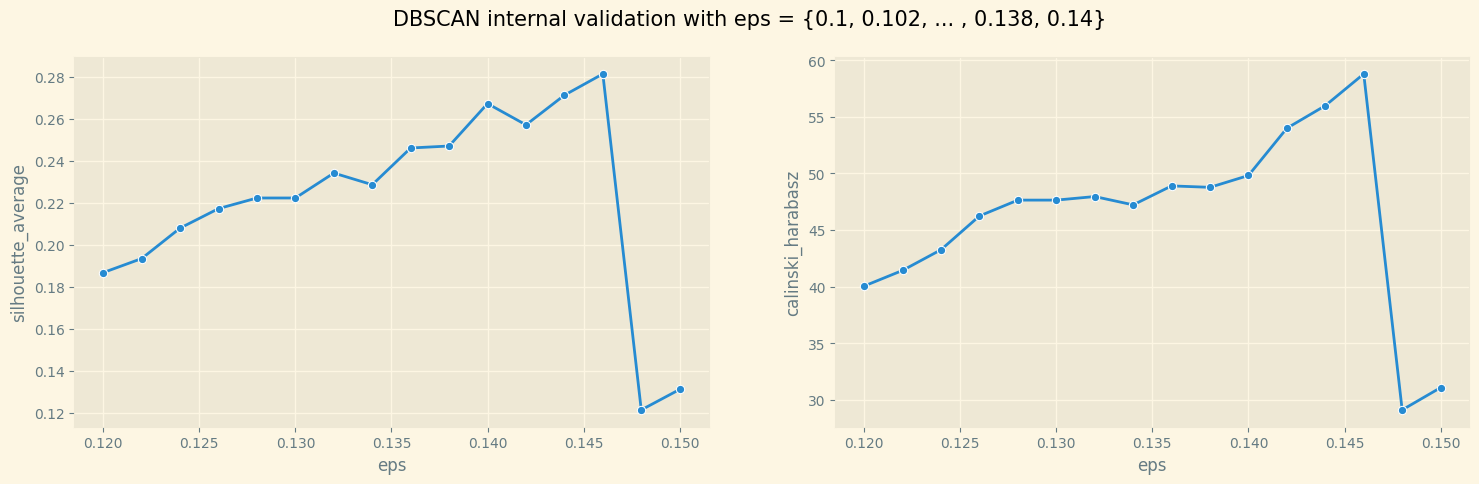

<Figure size 640x480 with 0 Axes>

In [100]:
# thanks to how fast modern computer can be, I can easily run complex algorithm iteratively in just seconds, so I can try as much hyperparameters in a reasonable amount of time
eps_array = np.arange(0.12, 0.152, 0.002)

# similar to k-means
acceptable_eps = []
silhouette_avgs = []
silhouette_values = []
labels = []
ch_index = []
normal_df_list = {}

for eps in eps_array:
    # thanks to how computer works, I need to round the values of eps so if I need to reference it, I won't get any error
    eps_round = np.round(eps, 3)

    # create the model and then fit the data
    dbscan = DBSCAN(eps=eps_round, min_samples=6).fit(normal_df)

    # create a temporary copy of the normal_df, merge with the labels, and remove the outliers
    # this is to then store into the normal_df_list
    temp_df = normal_df.copy()
    temp_df['label'] = dbscan.labels_

    # check if a hyperparameter caused the model to produce only one cluster
    if len(np.unique(temp_df['label'])) == 1:

        # if the hyperparameter only produced one cluster, skip, because it's just worthless if it can't cluster anything
        print(f'Note: eps={eps_round} only produced one cluster!')
        continue

    # append the dataframe into the dictionary of normal_df
    normal_df_list[f'{eps_round}'] = temp_df

    # append the scores
    acceptable_eps.append(eps_round)
    silhouette_avgs.append(silhouette_score(temp_df.drop(columns=['label']), temp_df['label']))  # the silhouette score, taking in the dataset and the corresponding clustering
    silhouette_values.append(silhouette_samples(temp_df.drop(columns=['label']), temp_df['label']))     # the silhouette values, to be plotted on the silhouette plot
    labels.append(temp_df['label'])   # appending the labels 
    ch_index.append(calinski_harabasz_score(temp_df.drop(columns=['label']), temp_df['label']))     # the calinski_harabasz index, similar to silhouette

scores = pd.DataFrame({
    'eps' : acceptable_eps,
    'silhouette_average' : silhouette_avgs,
    'silhouette_values' : silhouette_values,
    'labels' : labels,
    'calinski_harabasz' : ch_index
})

# 3 subplots lay horizontally, with each graph showing the score
fig, axes = plt.subplots(1, 2)

# manually set the width of the figures longer
fig.set_figwidth(18)
fig.suptitle('DBSCAN internal validation with eps = {0.1, 0.102, ... , 0.138, 0.14}', fontsize=15)

col_list = ['silhouette_average', 'calinski_harabasz']

# iterate over the list of axes and plot a lineplot for each axes
for i, ax in enumerate(axes):
    sns.lineplot(data=scores, x='eps', y=col_list[i], ax=ax, marker='o')

print(f'Highest silhouette average: {np.max(scores["silhouette_average"])}')
print(f'Highest silhouette average eps={scores.loc[scores["silhouette_average"].idxmax(), "eps"]}')
print(f'Highest calinski_harabasz average: {np.max(scores["calinski_harabasz"])}')
print(f'Highest calinski_harabasz average eps={scores.loc[scores["calinski_harabasz"].idxmax(), "eps"]}')

plt.show()
plt.clf()

We can already see that eps=0.146 produces the best results, far surpass all the results I have gotten from K-Means. From 0.12, we can confirm that the results do indeed improve as the value decrease. It reaches its peak at eps=0.146 before cutting off. So our "local minimum" or "local maximum" occurs at eps=0.146. I will try to plot the silhouette graph at eps=0.146 and see how it looks like.

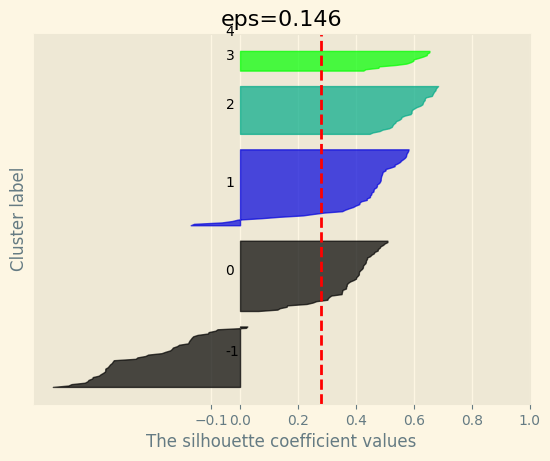

In [101]:
y_lower = 10
eps = 0.146
sample_silhouette_values = scores.loc[scores[scores['eps'] == eps].index[0], 'silhouette_values']
for i in range(np.min(normal_df_list[str(eps)]['label']), len(np.unique(normal_df_list[str(eps)]['label']))):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[normal_df_list[str(eps)]['label'] == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = cm.nipy_spectral(float(i) / len(np.unique(normal_df_list[str(eps)]['label'])))
    plt.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

plt.title(f'eps={eps}')
plt.xlabel("The silhouette coefficient values")
plt.ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
plt.axvline(x=scores.loc[scores[scores['eps'] == eps].index[0], 'silhouette_average'], color="red", linestyle="--")

plt.yticks([])  # Clear the y-axis labels / ticks
plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.show()

We can now clearly see none of the data points are below 0, and the tip of every cluster are above 0.6. The only downside is that one of the cluster is thin, with the score way ahead of others, making it more inconsistent with the other clusters. This means this cluster is highly isolated from the other clusters, and consists of a few data points.

I will finally plot the 3D graph to see how the clustering looks like.

In [105]:
# plot the 3D scatterplot
final_df = customer_df2.copy(deep=True)
final_df['label'] = scores.loc[scores[scores['eps'] == eps].index[0], 'labels']
fig = px.scatter_3d(final_df, 'Income', 'Spending', 'Age', 'label')
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

Seems like we have slightly too many outliers, probably because 6 MinPts is a bit too high. We should also consider having 4 or 5 MinPts. Also, I did not expect the low income high spending to merge with the medium income medium spending at the young age, and we seem to have one missing cluster, the low income low spending, which is classified as outlier.

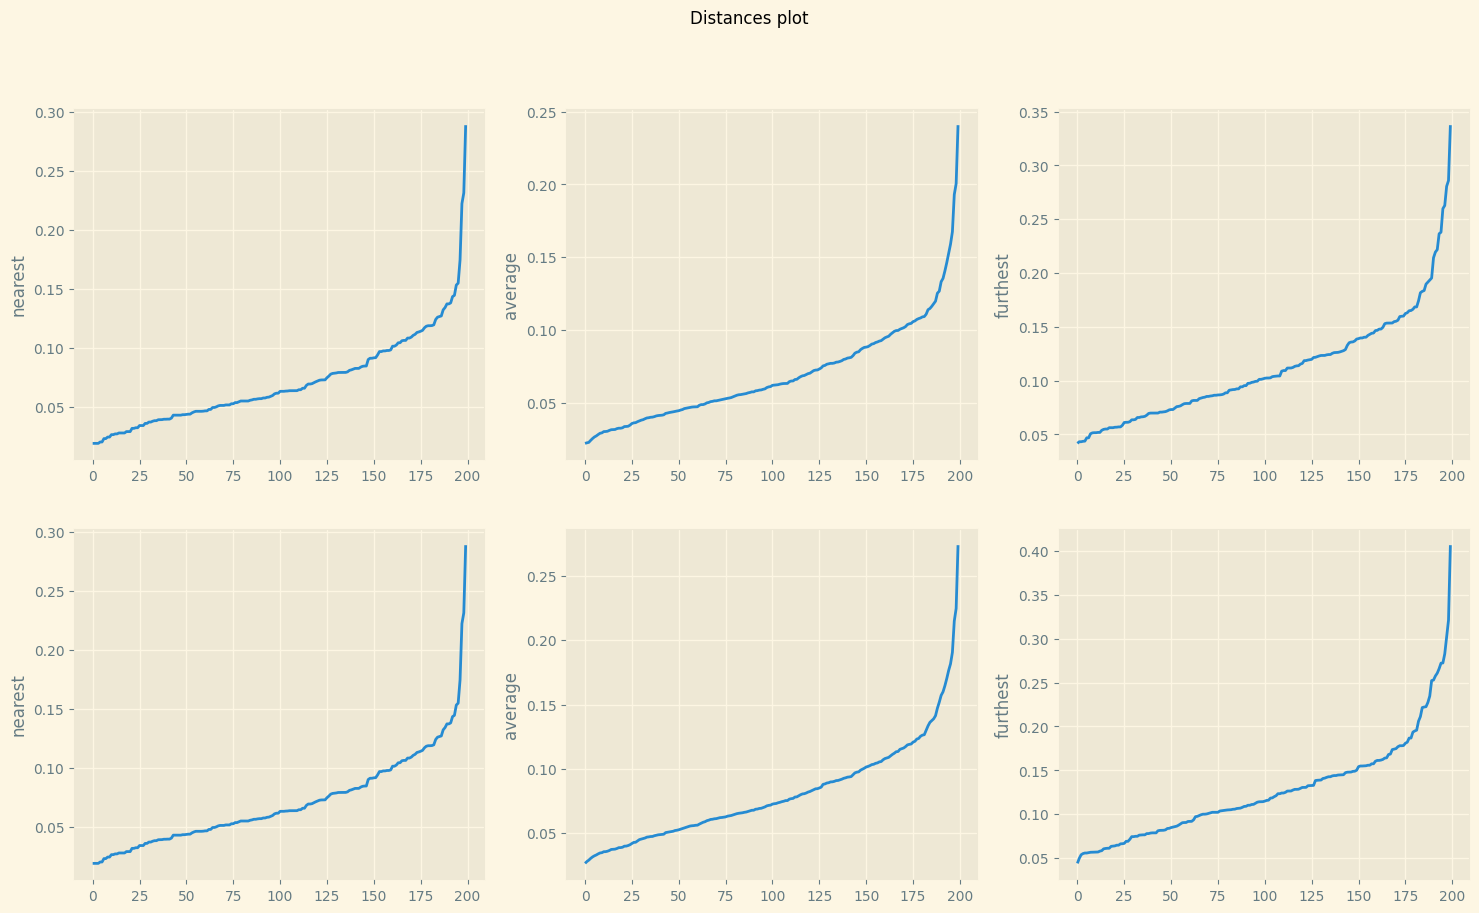

In [33]:
neighbours_4 = NearestNeighbors(n_neighbors=4).fit(normal_df)    
neighbours_5 = NearestNeighbors(n_neighbors=5).fit(normal_df)
distances_4, _ = neighbours_4.kneighbors(normal_df)   
distances_5, _ = neighbours_5.kneighbors(normal_df)

# wrangling the distance object a bit
distances_4 = np.sort(distances_4, axis=0)  
distances_5 = np.sort(distances_5, axis=0)  

# create a dataframe to store the nearest, average, and highest distances
distances_4_df = pd.DataFrame({'nearest' : distances_4[:,1], 'average' : np.mean(distances_4, axis=1), 'furthest' : distances_4[:,-1]})
distances_5_df = pd.DataFrame({'nearest' : distances_5[:,1], 'average' : np.mean(distances_5, axis=1), 'furthest' : distances_5[:,-1]})

# create subplots
fig, axes = plt.subplots(2, 3)

fig.set_figheight(10)
fig.set_figwidth(18)
fig.suptitle('Distances plot')

# iterate over columns, plot the distance graphs
for i, col in enumerate(distances_4_df.columns):
    sns.lineplot(data=distances_4_df, y=col, x=distances_4_df.index, ax=axes[0][i])

for i, col in enumerate(distances_5_df.columns):
    sns.lineplot(data=distances_5_df, y=col, x=distances_5_df.index, ax=axes[1][i])

plt.show()

So for 4 MinPts, the best Eps would be 0.15, 0.11, or 0.17. And for 5 MinPts, the best Eps would be 0.14, 0.13, or 0.2. But at this point, instead of putting those exact values, I will simply find the best hyperparameters within the range of the best epsilon from the distance plot above. So I will just find the best hyperparameters from eps=0.1 to eps=0.2, with 0.002 increment for each round.

Highest silhouette average: 0.2607843547453482
Highest silhouette average eps=0.124
Highest silhouette n=4
Highest calinski_harabasz average: 46.73228748152413
Highest calinski_harabasz average eps=0.12
Highest calinski_harabasz n=5


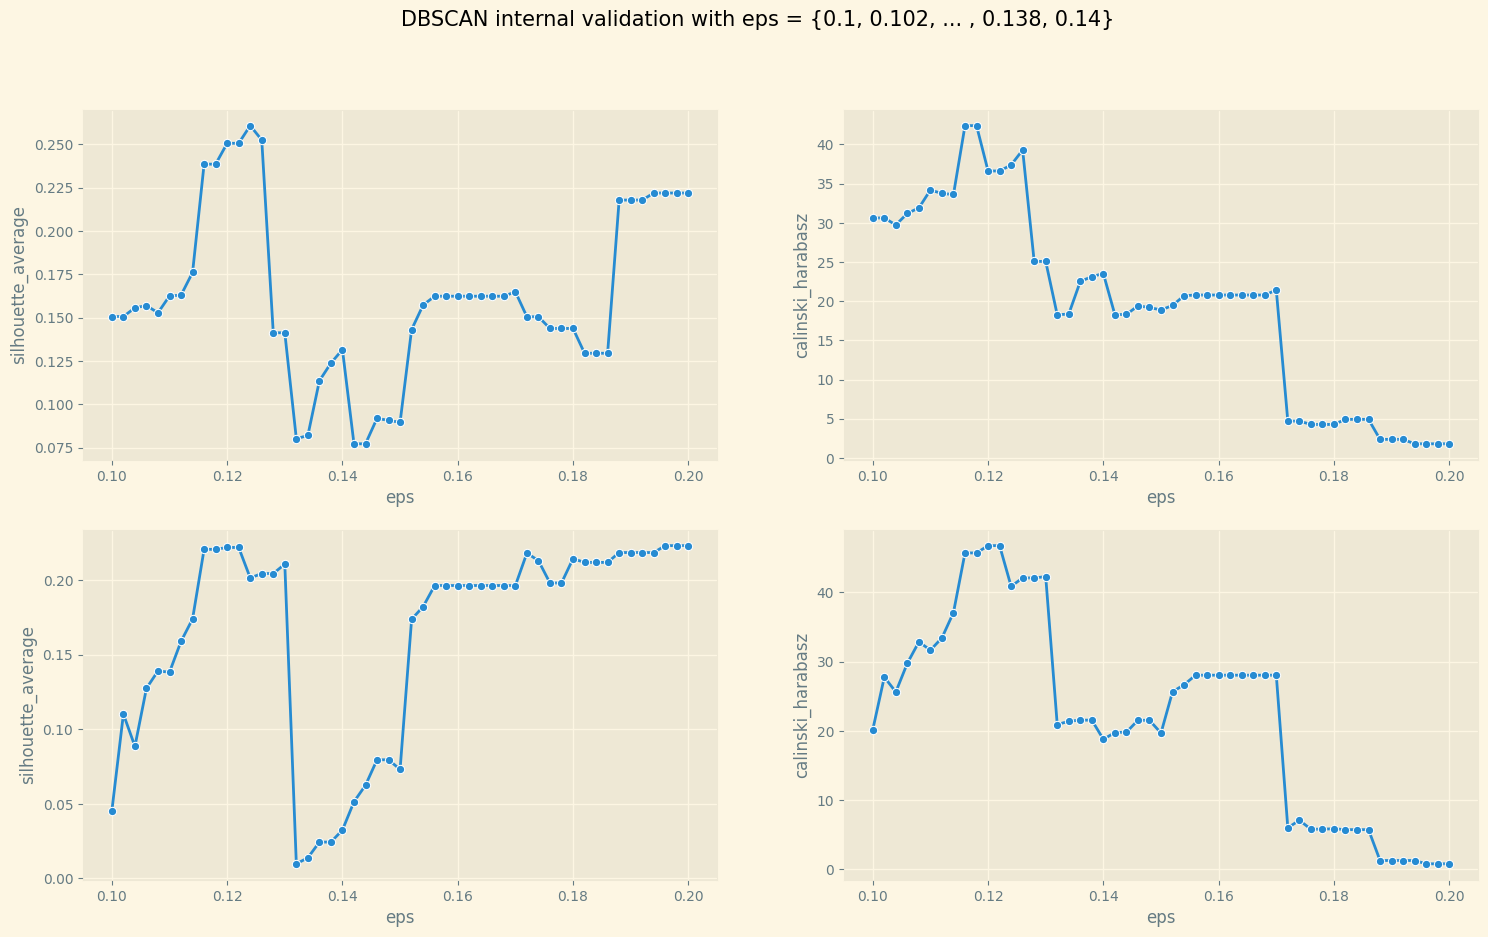

<Figure size 640x480 with 0 Axes>

In [108]:
eps_dict = {
    4 : np.arange(0.1, 0.202, 0.002),
    5 : np.arange(0.1, 0.202, 0.002)}

acceptable_eps = []
silhouette_avgs = []
silhouette_values = []
labels = []
n_list = []
ch_index = []
normal_df_list = {}

for n in list(eps_dict.keys()):
    for eps in eps_dict[n]:

        eps_round = np.round(eps, 3)

        dbscan = DBSCAN(eps=eps_round, min_samples=n).fit(normal_df)

        # create a temporary copy of the normal_df, merge with the labels, and remove the outliers
        # this is to then store into the normal_df_list
        temp_df = normal_df.copy()
        temp_df['label'] = dbscan.labels_

        # check if a hyperparameter caused the model to produce only one cluster
        if len(np.unique(temp_df['label'])) == 1:

            # if the hyperparameter only produced one cluster, skip, because it's just worthless if it can't cluster anything
            print(f'Note: eps={eps_round} only produced one cluster!')
            continue

        # append the dataframe into the dictionary of normal_df
        normal_df_list[f'{eps_round}_{n}'] = temp_df

        # append the scores
        n_list.append(n)
        acceptable_eps.append(eps_round)
        silhouette_avgs.append(silhouette_score(temp_df.drop(columns=['label']), temp_df['label']))  # the silhouette score, taking in the dataset and the corresponding clustering
        silhouette_values.append(silhouette_samples(temp_df.drop(columns=['label']), temp_df['label']))     # the silhouette values, to be plotted on the silhouette plot
        labels.append(temp_df['label'])   # appending the labels 
        ch_index.append(calinski_harabasz_score(temp_df.drop(columns=['label']), temp_df['label']))     # the calinski_harabasz index, similar to silhouette

scores = pd.DataFrame({
    'n' : n_list,
    'eps' : acceptable_eps,
    'silhouette_average' : silhouette_avgs,
    'silhouette_values' : silhouette_values,
    'labels' : labels,
    'calinski_harabasz' : ch_index
})

fig, axes = plt.subplots(2, 2)

fig.set_figheight(10)
fig.set_figwidth(18)
fig.suptitle('DBSCAN internal validation with eps = {0.1, 0.102, ... , 0.198, 0.2}', fontsize=15)

col_list = ['silhouette_average', 'calinski_harabasz']

# iterate over the list of axes and plot a lineplot for each axes
for i, ax in enumerate(axes[0]):
    sns.lineplot(data=scores[scores['n'] == 4], x='eps', y=col_list[i], ax=ax, marker='o')

for i, ax in enumerate(axes[1]):
    sns.lineplot(data=scores[scores['n'] == 5], x='eps', y=col_list[i], ax=ax, marker='o')

print(f'Highest silhouette average: {np.max(scores["silhouette_average"])}')
print(f'Highest silhouette average eps={scores.loc[scores["silhouette_average"].idxmax(), "eps"]}')
print(f'Highest silhouette n={scores.loc[scores["silhouette_average"].idxmax(), "n"]}')
print(f'Highest calinski_harabasz average: {np.max(scores["calinski_harabasz"])}')
print(f'Highest calinski_harabasz average eps={scores.loc[scores["calinski_harabasz"].idxmax(), "eps"]}')
print(f'Highest calinski_harabasz n={scores.loc[scores["calinski_harabasz"].idxmax(), "n"]}')

plt.show()
plt.clf()



Interestingly, the silhouette score and the calinski harabasz doesn't agree on the best hyperparameters. I'll have to decide based on domain knowledge instead. In this clustering,we would want to create clusters based on spending score, income, and age (gender don't seem to matter much), and then find the most valuable cluster in which the mall should do something to retain them, and the only way how is to know more about them. I most definitely have to do clustering such that I can have clear clusters with its own identity such as "low income high spending young age". In this case, I'll probably follow calinski harabasz as it emphasises well-defined clusters with clear separation and compactness, but I'll plot the silhouette graphs for both the highest silhouette score and highest calinski harabasz index.

One more thing to note is that, for both n=4 and n=5, when the epsilon continues to go up, approaching 0.2, the silhouette score actually went up again, but the calinkski harabasz index score drop all the way to 0. It should mean the clustering fail to work, but it still somehow satisfies the silhouette score, maybe because there's only one cluster as the epsilon is quite high and one outlier cluster that is surrounding the one cluster.

In [109]:
def plot_one_silhouette(eps, n):
    score = scores.loc[scores[(scores['eps'] == eps) & (scores['n'] == n)].index[0]]
    y_lower = 10
    sample_silhouette_values = score['silhouette_values']
    for i in range(np.min(score['labels']), len(np.unique(score['labels']))):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[score['labels'] == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / len(np.unique(score['labels'])))
        plt.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title(f'eps={eps} & n={n}')
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=score['silhouette_average'], color="red", linestyle="--")

    plt.yticks([])  # Clear the y-axis labels / ticks
    plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()

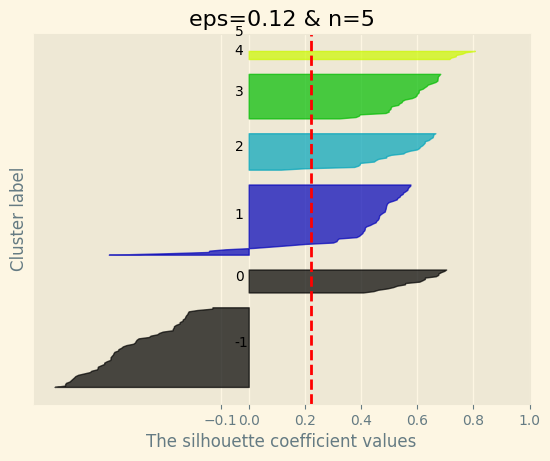

In [110]:
eps = 0.12
n = 5
plot_one_silhouette(eps, n)

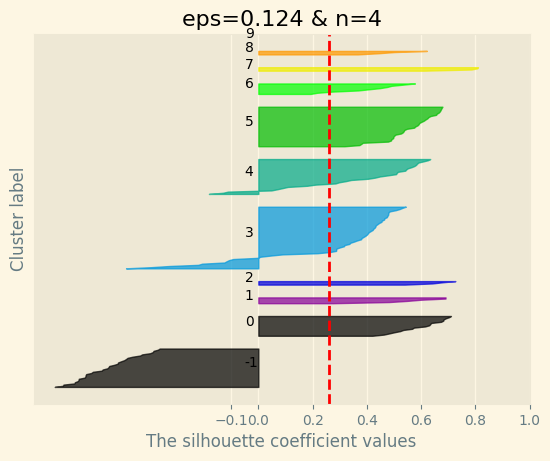

In [111]:
eps = 0.124
n = 4
plot_one_silhouette(eps, n)

For the highest silhouette score, it created 9 different clusters, without including the outliers. This is more clusters than I hoped for. And not only that, two of the clusters have values dip way below 0, and some clusters have way less data points than the biggest one. For the highest calinski harabasz index, it seems much better with 5 clusters but again, one of the clusters has value dip way below 0, and one of the cluster has way less data points than the biggest one. I'll just plot the 3D scatterplot with the highest calinski harabasz index.

In [113]:
final_df = customer_df2.copy(deep=True)
final_df['label'] = scores.loc[scores[(scores['eps'] == 0.12) & (scores['n'] == 5)].index[0]]['labels']
fig = px.scatter_3d(final_df, 'Income', 'Spending', 'Age', 'label')
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

Unfortunately, the clusters created are still not what I hope to see when I inspect the data manually and with K-Means. Sure, there 4 clusters that I am expecting to see, but the other two are drawfed by outliers or simply one tiny cluster (The low spending region). To be fair, that's because those region seem to be pretty low in density as compared to the rest, which is why they are considered as outliers. However, if I increase the epsilon, it still doesn't seem to work, and too high will result in clusters merging.

So in conclusion, DBSCAN unfortunately doesn't seem to work out as well as K-Means, but it did well on clustering the 4 of the clusters that I expect, which are the ones in the region with medium and high spending.

In the end, K-Means would be the best model for our clustering. By referring back to the 3D scatterplot for the K-Means, we can understand the all the predicted clusters as follow:
1. Low income high spending low age: This cluster is basically young people in their 20s who may be working on their first job that might not pay very well. At this age, most people will feel materialistic when they get their first salary and will most likely to go on a spending spree with their first incomes.
2. High income high spending low-middle age: This cluster consists of people in their 30s who are working with a much higher salary than those in the 20s. They may also feel materialistic or they may be willing to spend more money on expensive goods thanks to their high income.
3. Medium income medium spending low age: This group of people in their 20s or 30s may have another been working on an average job and is probably more aware of their spending habits, thus they have lesser overall spending power than the last two clusters.
4. Medium income medium spending middle-old age: This cluster is the same as the third one, but consists of people in their 40s and older. They are probably also in their average job and is more aware of their spending habits as well.
5. Low income low spending old age: This group of people mostly in their 50s or older may be from low income background due to their low income and they may only buy the cheapest of stuff, thus having low spending power.
6. High income low spending middle age: This group of people consisting of age 30s, 40s, and 50s have high income but low spending power. They may be very well aware of their spending and sees no needs on spending much so they only buy the bare essential while earning more than some of the others.

At the end of the day, the most valuable customers are those who have high spending power. Cluster 1 and 2 are those with high spending power. But since cluster 1 are youths in their 20s who probably found their first job and earning their first income and feeling materialistic, they can't just spend too much as their incomes aren't high enough, and they may not have saved up a lot of money yet. Hence, cluster 2 would be the most valuable as those people in their 30s earning high incomes would have saved a lot of money to spend on more expensive goods. So, retaining them by getting them to buy luxury products can probably work out to be more profitable for the mall.

## References:

Kochhar, R. (2021) Are you in the global middle class? find out with our income calculator, Pew Research Center. Available at: https://www.pewresearch.org/short-reads/2021/07/21/are-you-in-the-global-middle-class-find-out-with-our-income-calculator/ (Accessed: 27 July 2023). 

Malato, G. (2023) An introduction to the shapiro-wilk test for normality, Built In. Available at: https://builtin.com/data-science/shapiro-wilk-test (Accessed: 29 July 2023).

Ellis, C. (2022) When to use gaussian mixture models, Crunching the Data. Available at: https://crunchingthedata.com/when-to-use-gaussian-mixture-models/ (Accessed: 31 July 2023). 

Ester, M. et al. (1996) A Density-Based Algorithm for Discovering Clusters [Preprint]. 

Mullin, T. (2020) DBSCAN parameter estimation using Python, Medium. Available at: https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd (Accessed: 1 August 2023). 